The goal of this document is to provide evidence that normalizing embedding vectors before use in a classification model is appropriate. We do this by showing the average distance of vectors in an embedded graph increases with respect to network size.

In [11]:
import shelve
from os.path import join as jn

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import EMB

ROOT = jn("..", "..", "")
FIGURES = jn(ROOT, "results", "figures", "")
DATA = jn(ROOT, "data", "")

We fix number of nodes between 100 and 1000, for simplicity with N2V embedding. We also maintain a constant $\langle k \rangle=2$ probability of any two nodes being connected.

In [4]:
Ns = np.arange(100, 1100, 100)

We begin by embedding the graphs and storing this vector and edge data

In [5]:
vectors_n2v = dict()  # N -> vectors
vectors_le = dict()  # N -> vectors
vectors_isomap = dict()  # N -> vectors
vectors_hope = dict()  # N -> vectors
edge_sets = dict()  # N -> edges
for N in Ns:
    print(f"Embedding N={N}...")

    G = nx.erdos_renyi_graph(N, 2/N)
    edge_sets[N] = G.edges()

    vectors_n2v[N] = EMB.embeddings.embed_N2V(G, dimensions=128)
    vectors_le[N] = EMB.embeddings.embed_LE(G, k=128)
    vectors_isomap[N] = EMB.embeddings.embed_Isomap(G, dimensions=128)
    vectors_hope[N] = EMB.embeddings.embed_HOPE(G, dimensions=128)


Embedding N=100...


INFO - Encountered type error, retrying with dense eigensolver...
WARNING - Encountered graph with n <= dimensions; forcing dimensions = n-1.


Embedding N=200...
Embedding N=300...
Embedding N=400...
Embedding N=500...
Embedding N=600...
Embedding N=700...
Embedding N=800...
Embedding N=900...
Embedding N=1000...


In [6]:
with shelve.open(jn(DATA, "data_avg-dists.shelf")) as shelf:
    shelf["vectors_n2v"] = vectors_n2v
    shelf["vectors_le"] = vectors_le
    shelf["vectors_isomap"] = vectors_isomap
    shelf["vectors_hope"] = vectors_hope
    shelf["edge_sets"] = edge_sets

We then calculate the mean Euclidean distance between two sets of vectors
- All embedded node vectors
- The vectors associated to edges present in the graph

If $V = \{\vec{x} \in \mathbb{R}^{128} \mid \vec{x} \text{ is the embedding of node x} \}$, then the vectors we are finding the mean distance between in the two points above are:
- $V$
- $\{\vec{x} - \vec{y} \in \mathbb{R}^{128} \mid (x,y) \in G \land \vec{x},\vec{y} \in V \}$

In [7]:
def average_distance(vectors):
    N = len(vectors)
    distances = []
    for i in range(N):
        for j in range(i):  # metrics are symmetric
            x = vectors[i]
            y = vectors[j]

            d = np.linalg.norm(x-y)
            distances.append(d)

    return np.mean(distances)

def edge_vectors(vectors, edges):
    edge_vectors = []
    for edge in edges:
        src, tgt = edge
        v = np.array(vectors[src]) - np.array(vectors[tgt])
        edge_vectors.append(v)

    return edge_vectors

In [8]:
avg_dists_n2v = {
    N: average_distance(vectors)
    for N, vectors in vectors_n2v.items()
}
avg_edge_dists_n2v = {
    N: average_distance(edge_vectors(vectors_n2v[N], edge_sets[N]))
    for N in Ns
}

avg_dists_le = {
    N: average_distance(vectors)
    for N, vectors in vectors_le.items()
}
avg_edge_dists_le = {
    N: average_distance(edge_vectors(vectors_le[N], edge_sets[N]))
    for N in Ns
}

avg_dists_isomap = {
    N: average_distance(vectors)
    for N, vectors in vectors_isomap.items()
}
avg_edge_dists_isomap = {
    N: average_distance(edge_vectors(vectors_isomap[N], edge_sets[N]))
    for N in Ns
}

avg_dists_hope = {
    N: average_distance(vectors)
    for N, vectors in vectors_hope.items()
}
avg_edge_dists_hope = {
    N: average_distance(edge_vectors(vectors_hope[N], edge_sets[N]))
    for N in Ns
}

Now we examine our results

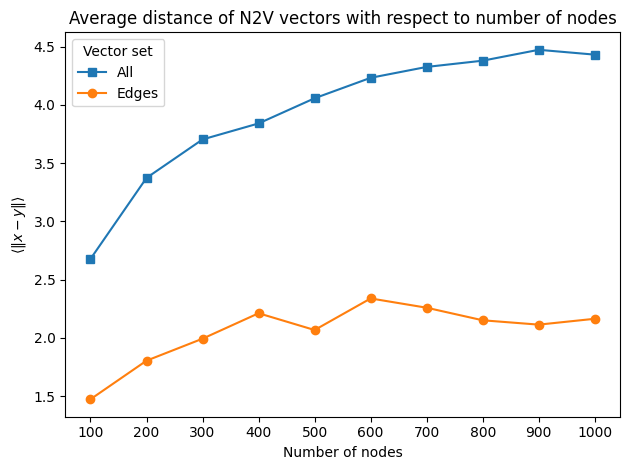

In [24]:
plt.figure()

plt.plot(
    Ns, avg_dists_n2v.values(),
    label="All",
    marker="s"
)
plt.plot(
    Ns, avg_edge_dists_n2v.values(),
    label="Edges",
    marker="o"
)
plt.legend(title="Vector set")
plt.xticks(Ns)

plt.xlabel("Number of nodes")
plt.ylabel(r"$\langle \|x-y\| \rangle$")
plt.title("Average distance of N2V vectors with respect to number of nodes")

plt.tight_layout()
plt.savefig(jn(FIGURES, "figure_dists-v-size_embedding-N2V.png"), transparent=False, facecolor="white", dpi=600)

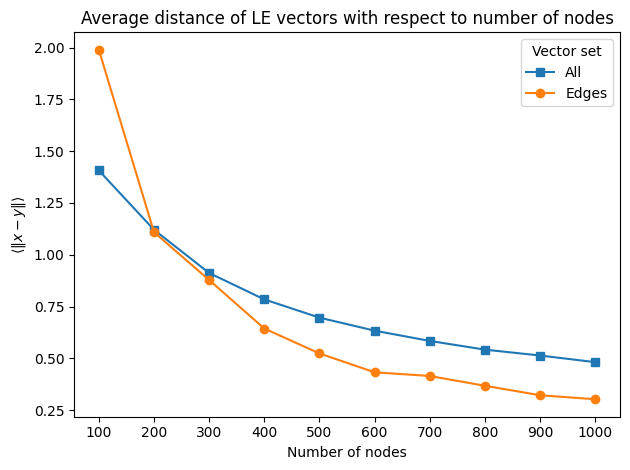

In [23]:
plt.figure()

plt.plot(
    Ns, avg_dists_le.values(),
    label="All",
    marker="s"
)
plt.plot(
    Ns, avg_edge_dists_le.values(),
    label="Edges",
    marker="o"
)
plt.legend(title="Vector set")
plt.xticks(Ns)

plt.xlabel("Number of nodes")
plt.ylabel(r"$\langle \|x-y\| \rangle$")
plt.title("Average distance of LE vectors with respect to number of nodes")

plt.tight_layout()
plt.savefig(jn(FIGURES, "figure_dists-v-size_embedding-LE.png"), transparent=False, facecolor="white", dpi=600)

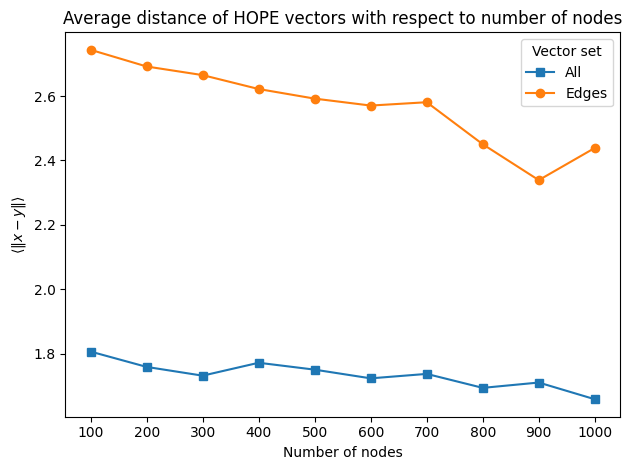

In [25]:
plt.figure()

plt.plot(
    Ns, avg_dists_hope.values(),
    label="All",
    marker="s"
)
plt.plot(
    Ns, avg_edge_dists_hope.values(),
    label="Edges",
    marker="o"
)
plt.legend(title="Vector set")
plt.xticks(Ns)

plt.xlabel("Number of nodes")
plt.ylabel(r"$\langle \|x-y\| \rangle$")
plt.title("Average distance of HOPE vectors with respect to number of nodes")

plt.tight_layout()
plt.savefig(jn(FIGURES, "figure_dists-v-size_embedding-HOPE.png"), transparent=False, facecolor="white", dpi=600)

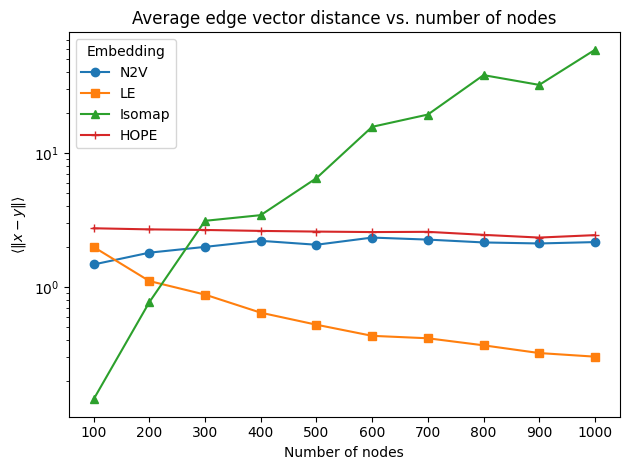

In [19]:
plt.figure()

plt.plot(
    Ns, avg_edge_dists_n2v.values(),
    label="N2V",
    marker="o"
)
plt.plot(
    Ns, avg_edge_dists_le.values(),
    label="LE",
    marker="s"
)
plt.plot(
    Ns, avg_edge_dists_isomap.values(),
    label="Isomap",
    marker="^"
)
plt.plot(
    Ns, avg_edge_dists_hope.values(),
    label="HOPE",
    marker="+"
)
plt.yscale("log")

plt.legend(title="Embedding")
plt.xticks(Ns)

plt.xlabel("Number of nodes")
plt.ylabel(r"$\langle \|x-y\| \rangle$")
plt.title("Average edge vector distance vs. number of nodes")

plt.tight_layout()
plt.savefig(jn(FIGURES, "figure_log-edge-dists-v-size.png"), transparent=False, facecolor="white", dpi=600)

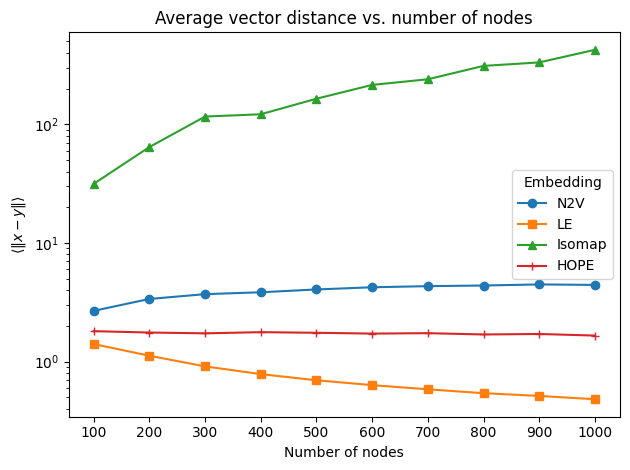

In [22]:
plt.figure()

plt.plot(
    Ns, avg_dists_n2v.values(),
    label="N2V",
    marker="o"
)
plt.plot(
    Ns, avg_dists_le.values(),
    label="LE",
    marker="s"
)
plt.plot(
    Ns, avg_dists_isomap.values(),
    label="Isomap",
    marker="^"
)
plt.plot(
    Ns, avg_dists_hope.values(),
    label="HOPE",
    marker="+"
)
plt.yscale("log")

plt.legend(title="Embedding")
plt.xticks(Ns)

plt.xlabel("Number of nodes")
plt.ylabel(r"$\langle \|x-y\| \rangle$")
plt.title("Average vector distance vs. number of nodes")

plt.tight_layout()
plt.savefig(jn(FIGURES, "figure_logdists-v-size.png"), transparent=False, facecolor="white", dpi=600)